In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2022/train_labels.csv
/kaggle/input/tabular-playground-series-apr-2022/train.csv
/kaggle/input/tabular-playground-series-apr-2022/test.csv


In [4]:
!pip install -Uqq fastbook
import fastbook

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.3 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.3 requires numpy~=1.19.2, but you have numpy 1.21.5 which is incompatible.
tensorflow 2.6.3 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.3 requires wrapt~=1.12.1, but you have wrapt 1.14.0 which is incompatible.
tensorflow-transform 1.7.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.7.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.3 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.3 which i

In [5]:
from fastai.tabular.all import *
from fastbook import *

In [6]:
fastbook.setup_book()

In [7]:
train = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
t_lbls = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2022/test.csv')
ss = pd.read_csv('../input/tabular-playground-series-apr-2022/sample_submission.csv')

In [8]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [9]:
def color(x):
    if x <= 0.25:
        return 0
    elif x >= 0.75:
        return 0.5
    else:
        return 1

sub_stat = t_lbls.merge(train[['sequence', 'subject']], on='sequence', how='left')\
.drop_duplicates().groupby('subject').agg({'state':['mean', 'count']}).reset_index()
sub_stat.columns = sub_stat.columns.map('_'.join)
sub_stat['text'] = 'Subject - <b>' + sub_stat["subject_"].astype('str') + \
'</b> <br>State - <b>' + round(sub_stat["state_mean"], 2).astype('str') + \
'</b> <br>Count - <b>' + sub_stat["state_count"].astype('str') + '</b> <extra></extra>'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.


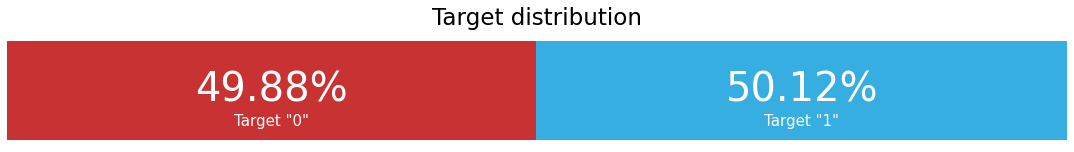

In [10]:
x=t_lbls.groupby(['state'])['state'].count()
y=len(t_lbls)
r=((x/y)).round(4)

mf_ratio = pd.DataFrame(r).T

fig, ax = plt.subplots(1,1,figsize=(19, 2))
plt.title('Target distribution', size=23, y=1.05)

ax.barh(mf_ratio.index, mf_ratio[0], 
        color='#c21b1b', alpha=0.9, label='Zero')
ax.barh(mf_ratio.index, mf_ratio[1], left=mf_ratio[0], 
        color='#21a5de', alpha=0.9, label='One')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

ax.annotate(f"{mf_ratio[0]['state']*100}%", 
                   xy=(mf_ratio[0]['state']/2, 'state'),
                   va = 'center', ha='center',fontsize=40,
                   color='white')

ax.annotate('Target "0"', xy=(mf_ratio[0]['state']/2, -0.25),
                   va = 'center', ha='center',fontsize=15,
                   color='white')
    
ax.annotate(f"{mf_ratio[1]['state']*100}%", 
                   xy=(mf_ratio[0]['state']+mf_ratio[1]['state']/2, 'state'),
                   va = 'center', ha='center',fontsize=40,
                   color='white')
    
ax.annotate('Target "1"', xy=(mf_ratio[0]['state']+mf_ratio[1]['state']/2, -0.25),
                   va = 'center', ha='center',fontsize=15,
                   color='white')

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_visible(False)
    
plt.show()

In [11]:
from sklearn.preprocessing import StandardScaler
features = train.columns.tolist()[3:]

def sub_imp(x):
    if x < 25:
        return 0
    elif x > 95:
        return 2
    else:
        return 1

def prep(df):
    for feature in features:
        df[feature+'_lag1'] = df.groupby('sequence')[feature].shift(1)
        df[feature+'_back_lag1'] = df.groupby('sequence')[feature].shift(-1)
        
        df.fillna(0, inplace=True)
        df[feature+'_diff1'] = df[feature] - df[feature+'_lag1']
        
        # New features
        for window in [3,6,12]:
            df[feature+'_roll_'+str(window)+'_mean'] = df.groupby('sequence')[feature]\
            .rolling(window=window, min_periods=1).mean().reset_index(level=0,drop=True)
            
            df[feature+'_roll_'+str(window)+'_std'] = df.groupby('sequence')[feature]\
            .rolling(window=window, min_periods=1).std().reset_index(level=0,drop=True)
            
            df[feature+'_roll_'+str(window)+'_sum'] = df.groupby('sequence')[feature]\
            .rolling(window=window, min_periods=1).sum().reset_index(level=0,drop=True)
        
    # Experemental features
    """df['sens_00_06'] = df['sensor_00'] * df['sensor_06']
    df['sens_03_07'] = df['sensor_03'] * df['sensor_07']
    df['sens_03_11'] = df['sensor_03'] * df['sensor_11']

    for feature in ['sens_00_06', 'sens_03_07', 'sens_03_11']:
        df[feature + '_lag1'] = df.groupby('sequence')[feature].shift(1)
    df.fillna(0, inplace=True)"""
    
    # Subject feature
    sub_stat = df[['sequence', 'subject']].drop_duplicates().groupby('subject').agg({'sequence': 'count'})\
    .rename(columns={'sequence': 'count'}).reset_index()
    df = df.merge(sub_stat, on='subject', how='left')
    df['sub_imp'] = df['count'].apply(lambda x: sub_imp(x))
    df.drop('count', axis=1, inplace=True)
     
prep(train)
prep(test)

features = train.columns.tolist()[3:]
sc = StandardScaler()
train[features] = sc.fit_transform(train[features])
test[features] = sc.transform(test[features])


# Convert to dataframe



# Create principal components

abc=[]
groups = train["sequence"]
labels = t_lbls["state"]

train = train.drop(["sequence", "subject", "step"], axis=1).values
train = train.reshape(-1, 60, train.shape[-1])

test = test.drop(["sequence", "subject", "step"], axis=1).values
test = test.reshape(-1, 60, test.shape[-1])

In [12]:
labels

0        0
1        1
2        1
3        1
4        1
        ..
25963    1
25964    0
25965    1
25966    1
25967    0
Name: state, Length: 25968, dtype: int64

In [13]:
labels=pd.DataFrame(labels)

In [14]:
train=pd.DataFrame(train.reshape(-1,169),columns=features)

In [15]:
train=pd.concat([train,labels])

In [16]:
train.head()


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_00_lag1,sensor_00_back_lag1,sensor_00_diff1,sensor_00_roll_3_mean,sensor_00_roll_3_std,sensor_00_roll_3_sum,sensor_00_roll_6_mean,sensor_00_roll_6_std,sensor_00_roll_6_sum,sensor_00_roll_12_mean,sensor_00_roll_12_std,sensor_00_roll_12_sum,sensor_01_lag1,sensor_01_back_lag1,sensor_01_diff1,sensor_01_roll_3_mean,sensor_01_roll_3_std,sensor_01_roll_3_sum,sensor_01_roll_6_mean,sensor_01_roll_6_std,sensor_01_roll_6_sum,sensor_01_roll_12_mean,sensor_01_roll_12_std,sensor_01_roll_12_sum,sensor_02_lag1,sensor_02_back_lag1,sensor_02_diff1,sensor_02_roll_3_mean,sensor_02_roll_3_std,sensor_02_roll_3_sum,sensor_02_roll_6_mean,sensor_02_roll_6_std,sensor_02_roll_6_sum,sensor_02_roll_12_mean,sensor_02_roll_12_std,sensor_02_roll_12_sum,sensor_03_lag1,sensor_03_back_lag1,sensor_03_diff1,sensor_03_roll_3_mean,sensor_03_roll_3_std,sensor_03_roll_3_sum,sensor_03_roll_6_mean,sensor_03_roll_6_std,sensor_03_roll_6_sum,sensor_03_roll_12_mean,sensor_03_roll_12_std,sensor_03_roll_12_sum,sensor_04_lag1,sensor_04_back_lag1,sensor_04_diff1,sensor_04_roll_3_mean,sensor_04_roll_3_std,sensor_04_roll_3_sum,sensor_04_roll_6_mean,sensor_04_roll_6_std,sensor_04_roll_6_sum,sensor_04_roll_12_mean,sensor_04_roll_12_std,sensor_04_roll_12_sum,sensor_05_lag1,sensor_05_back_lag1,sensor_05_diff1,sensor_05_roll_3_mean,sensor_05_roll_3_std,sensor_05_roll_3_sum,sensor_05_roll_6_mean,sensor_05_roll_6_std,sensor_05_roll_6_sum,sensor_05_roll_12_mean,sensor_05_roll_12_std,sensor_05_roll_12_sum,sensor_06_lag1,sensor_06_back_lag1,sensor_06_diff1,sensor_06_roll_3_mean,sensor_06_roll_3_std,sensor_06_roll_3_sum,sensor_06_roll_6_mean,sensor_06_roll_6_std,sensor_06_roll_6_sum,sensor_06_roll_12_mean,sensor_06_roll_12_std,sensor_06_roll_12_sum,sensor_07_lag1,sensor_07_back_lag1,sensor_07_diff1,sensor_07_roll_3_mean,sensor_07_roll_3_std,sensor_07_roll_3_sum,sensor_07_roll_6_mean,sensor_07_roll_6_std,sensor_07_roll_6_sum,sensor_07_roll_12_mean,sensor_07_roll_12_std,sensor_07_roll_12_sum,sensor_08_lag1,sensor_08_back_lag1,sensor_08_diff1,sensor_08_roll_3_mean,sensor_08_roll_3_std,sensor_08_roll_3_sum,sensor_08_roll_6_mean,sensor_08_roll_6_std,sensor_08_roll_6_sum,sensor_08_roll_12_mean,sensor_08_roll_12_std,sensor_08_roll_12_sum,sensor_09_lag1,sensor_09_back_lag1,sensor_09_diff1,sensor_09_roll_3_mean,sensor_09_roll_3_std,sensor_09_roll_3_sum,sensor_09_roll_6_mean,sensor_09_roll_6_std,sensor_09_roll_6_sum,sensor_09_roll_12_mean,sensor_09_roll_12_std,sensor_09_roll_12_sum,sensor_10_lag1,sensor_10_back_lag1,sensor_10_diff1,sensor_10_roll_3_mean,sensor_10_roll_3_std,sensor_10_roll_3_sum,sensor_10_roll_6_mean,sensor_10_roll_6_std,sensor_10_roll_6_sum,sensor_10_roll_12_mean,sensor_10_roll_12_std,sensor_10_roll_12_sum,sensor_11_lag1,sensor_11_back_lag1,sensor_11_diff1,sensor_11_roll_3_mean,sensor_11_roll_3_std,sensor_11_roll_3_sum,sensor_11_roll_6_mean,sensor_11_roll_6_std,sensor_11_roll_6_sum,sensor_11_roll_12_mean,sensor_11_roll_12_std,sensor_11_roll_12_sum,sensor_12_lag1,sensor_12_back_lag1,sensor_12_diff1,sensor_12_roll_3_mean,sensor_12_roll_3_std,sensor_12_roll_3_sum,sensor_12_roll_6_mean,sensor_12_roll_6_std,sensor_12_roll_6_sum,sensor_12_roll_12_mean,sensor_12_roll_12_std,sensor_12_roll_12_sum,state
0,-0.073994,0.025755,0.529941,0.084226,-0.595617,-0.081710,-0.037993,0.113685,-0.022186,-0.372260,-0.513943,0.118173,0.121766,-0.000225,-0.169766,-0.046988,-0.178632,-0.411733,-0.062951,-0.309220,-0.453908,-0.066197,-0.403712,-0.492049,-0.066058,0.000215,0.031145,0.016212,0.060438,-0.279544,0.022072,0.095990,-0.310529,0.022995,0.115936,-0.341823,0.022710,0.094026,0.532866,1.761317,0.535341,-0.136074,0.243772,0.541476,-0.190531,0.172239,0.549452,-0.250604,0.136122,0.000676,-0.168132,0.053140,0.213720,-0.286893,0.076072,0.355093,-0.318792,0.077367,0.458984,-0.349291,0.078792,0.001016,0.098313,-0.493364,-0.964567,-0.826532,-0.329423,-1.541405,-0.860892,-0.2881

In [17]:
abc=train["state"]

In [18]:
abc="state"

In [19]:
#train=train.drop(["state"],axis=1)

In [20]:
test=pd.DataFrame(test.reshape(-1,169),columns=features)

In [21]:
data =TabularDataLoaders.from_df(train,path=".",y_names=abc,bs=256)
data.show_batch()

,sensor_07_roll_6_sum,sensor_06_roll_3_std,sensor_08_roll_12_mean,sensor_11_roll_6_sum,sensor_07_diff1,sensor_04_diff1,sensor_06_roll_6_sum,sensor_02_diff1,sensor_06_roll_3_mean,sensor_01_roll_12_sum,sensor_12_roll_12_sum,sensor_07_roll_3_std,sensor_03,sensor_02_roll_12_sum,sensor_01_roll_6_mean,sensor_11_roll_6_mean,sensor_03_roll_3_sum,sensor_10_roll_3_mean,sensor_08_roll_3_std,sensor_00_lag1,sensor_12_diff1,sensor_11_roll_3_std,sensor_09_roll_12_std,sensor_02_roll_6_sum,sensor_09_roll_3_sum,sensor_01_roll_3_std,sensor_00_roll_12_std,sensor_03_roll_6_mean,sensor_05_diff1,sensor_05_roll_3_mean,sensor_09_back_lag1,sensor_05_back_lag1,sensor_04_back_lag1,sensor_02_roll_3_sum,sensor_11_lag1,sensor_08,sensor_05_roll_12_std,sensor_05_roll_12_sum,sensor_01_roll_12_mean,sensor_03_roll_3_mean,sensor_08_roll_6_std,sensor_10_diff1,sensor_08_roll_12_sum,sensor_02_roll_6_std,sensor_07_roll_6_mean,sensor_00_roll_6_std,sensor_08_back_lag1,sensor_10_back_lag1,sensor_02_roll_12_mean,sensor_05_lag1,sensor_02_lag1,sensor_06_lag1,sensor_06_roll_3_sum,sensor_08_lag1,sensor_00_back_lag1,sensor_03_roll_3_std,sensor_06_roll_6_std,sensor_08_diff1,sensor_09_diff1,sensor_03_roll_12_sum,sensor_05_roll_3_sum,sensor_11_roll_3_mean,sensor_01_roll_12_std,sensor_12,sensor_00_roll_6_sum,sensor_02_roll_6_mean,sensor_03_roll_6_sum,sensor_05_roll_6_sum,sensor_01_roll_6_std,sensor_05_roll_6_mean,sensor_04_roll_6_mean,sensor_11_back_lag1,sensor_10_roll_12_std,sensor_09_roll_12_sum,sensor_10_roll_6_mean,sensor_02_roll_3_std,sensor_06_roll_6_mean,sensor_01_back_lag1,sensor_12_roll_6_sum,sensor_04_roll_3_mean,sensor_00_roll_3_std,sensor_08_roll_6_mean,sensor_10_roll_12_sum,sensor_12_lag1,sensor_04_roll_12_mean,sensor_04_roll_3_std,sensor_05_roll_12_mean,sensor_10_roll_12_mean,sensor_00_diff1,sensor_06_diff1,sensor_10_roll_3_sum,sensor_02_roll_3_mean,sensor_09_roll_6_mean,sensor_06,sensor_00_roll_6_mean,sensor_00,sensor_01_roll_6_sum,sensor_05_roll_3_std,sensor_05,sensor_06_back_lag1,sensor_03_roll_12_std,sensor_00_roll_12_mean,sensor_03_back_lag1,sensor_05_roll_6_std,sensor_08_roll_12_std,sensor_10_roll_6_sum,sensor_09_roll_6_std,sensor_07_back_lag1,sensor_11_diff1,sensor_12_roll_3_sum,sensor_03_roll_6_std,sensor_12_roll_6_mean,sensor_11_roll_12_sum,sensor_09_roll_3_std,sensor_00_roll_3_sum,sensor_09_lag1,sensor_02_roll_12_std,sensor_04_lag1,sensor_06_roll_12_std,sensor_01_roll_3_mean,sensor_07_roll_12_std,sensor_08_roll_3_sum,sensor_12_back_lag1,sensor_01_lag1,sensor_06_roll_12_mean,sensor_11,sensor_04,sensor_03_roll_12_mean,sensor_12_roll_3_mean,sensor_01,sensor_10,sensor_08_roll_3_mean,sensor_02,sensor_04_roll_6_std,sensor_07_roll_3_mean,sensor_04_roll_3_sum,sensor_03_diff1,sensor_08_roll_6_sum,sensor_09_roll_12_mean,sensor_07_roll_12_sum,sensor_09_roll_6_sum,sensor_11_roll_3_sum,sensor_12_roll_6_std,sensor_01_roll_3_sum,sensor_12_roll_12_mean,sensor_06_roll_12_sum,sensor_02_back_lag1,sensor_07_lag1,sensor_00_roll_3_mean,sensor_04_roll_6_sum,sensor_10_roll_6_std,sensor_09,sensor_07_roll_12_mean,sensor_00_roll_12_sum,sensor_04_roll_12_sum,sensor_10_lag1,sensor_11_roll_12_std,sensor_10_roll_3_std,sensor_01_diff1,sensor_09_roll_3_mean,sensor_11_roll_6_std,sensor_07_roll_6_std,sensor_07_roll_3_sum,sensor_04_roll_12_std,sensor_11_roll_12_mean,sensor_12_roll_12_std,sensor_03_lag1,sensor_07,sensor_12_roll_3_std,state
0,-0.171042,0.069405,0.168337,-0.084238,-0.667764,-0.227342,0.185698,0.006105,0.471983,0.142125,0.001641,0.193364,-0.840728,-0.065098,0.291362,-0.066922,-0.069163,0.087479,0.005668,-0.094502,-0.001161,0.145644,-0.347751,-0.056776,0.349861,0.129010,-0.157870,-0.122821,-0.365490,0.650886,-0.466004,0.268888,0.313840,-0.052750,0.431613,0.199961,0.995470,-0.224301,0.066759,-0.065324,-0.064939,-0.221309,0.295913,-0.190531,-0.141239,-0.125794,0.111888,-0.311512,-0.051431,-0.640159,-0.051984,0.050655,0.489759,-0.246353,-0.422062,0.396525,0.038520,0.262595,0.233793,-0.544203,0.686517,-0.116924,-0.076290,-0.001673,0.456790,-0.050838,-0.156693,-1.960899,-0.004811,-1.5

In [22]:
from sklearn.metrics import roc_auc_score  


In [23]:
class roc(Callback):
    '''
    Updated on March 28 2019 to reflect new change in FastAI's Callback
    ROC_AUC metric callback for fastai. Compute ROC score over each batch and returns the average over batches.
    TO DO: rolling average
    '''
    def on_epoch_begin(self, **kwargs):
        self.total = 0
        self.batch_count = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = F.softmax(last_output, dim=1)
        # roc_auc_score does not work on batches which does not contain both classes.
        try:
            roc_score = roc_auc_score(to_np(last_target), to_np(preds[:,1]))
            self.total += roc_score
            self.batch_count += 1
        except:
            pass
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, self.total/self.batch_count)

In [ ]:
def CrossEntropyLossFlat

In [24]:
learn=tabular_learner(data,layers=[768,512,256,128],loss_func=CrossEntropyLossFlat(min.long()),opt_func=Adam,metrics=roc,lr=0.01,n_out=25)

AttributeError: 'builtin_function_or_method' object has no attribute 'long'

In [ ]:
learn.fit_one_cycle(20)

In [ ]:
learn.show_results()